#Presentación del Trabajo
##Trabajo Práctico n°2
###Electrocardiograma
####Grupo 5 - Integrantes:
*   BERETERBIDE, Cecilia María
*   MASSONE, Thiago
*   SCALISE, Zarina Cristal

####Profesores
* Aylin Aghata Vazquez Chenlo
* Francisco Tassara
* Roberto Sebastián Tomás






#Introducción
El objetivo de este ejercicio fue realizar la interfaz de registro, detectar de manera online la frecuencia cardíaca mediante el algoritmo de Pan y Tompkins, y a partir de un registro levantado analizar el intervalo QT del ECG.

# Desarrollo


## 1. Interfaz y algoritmo Pan&Tompkins

Con el fin de explicar el trabajo desarrollado, se toma como ejemplo un registro levantado. La interfaz permite ingresar los datos del paciente, establecer una conexión con la placa de arduino, y realizar un registro de información de aplitud y tiempo del electrocardiograma. Esta información se guarda en los correspondientes archivos, y se grafica en tiempo real en la interfaz. A su vez, la misma muestra el valor de frecuencia cardíaca calculada con los datos. A continuación se muestra una captura de pantalla de un registro de datos de un paciente online. Se puede apreciar que, al momento de realizar la captura, el paciente presenta una frecuencia cardiaca de 79 latidos por minuto.




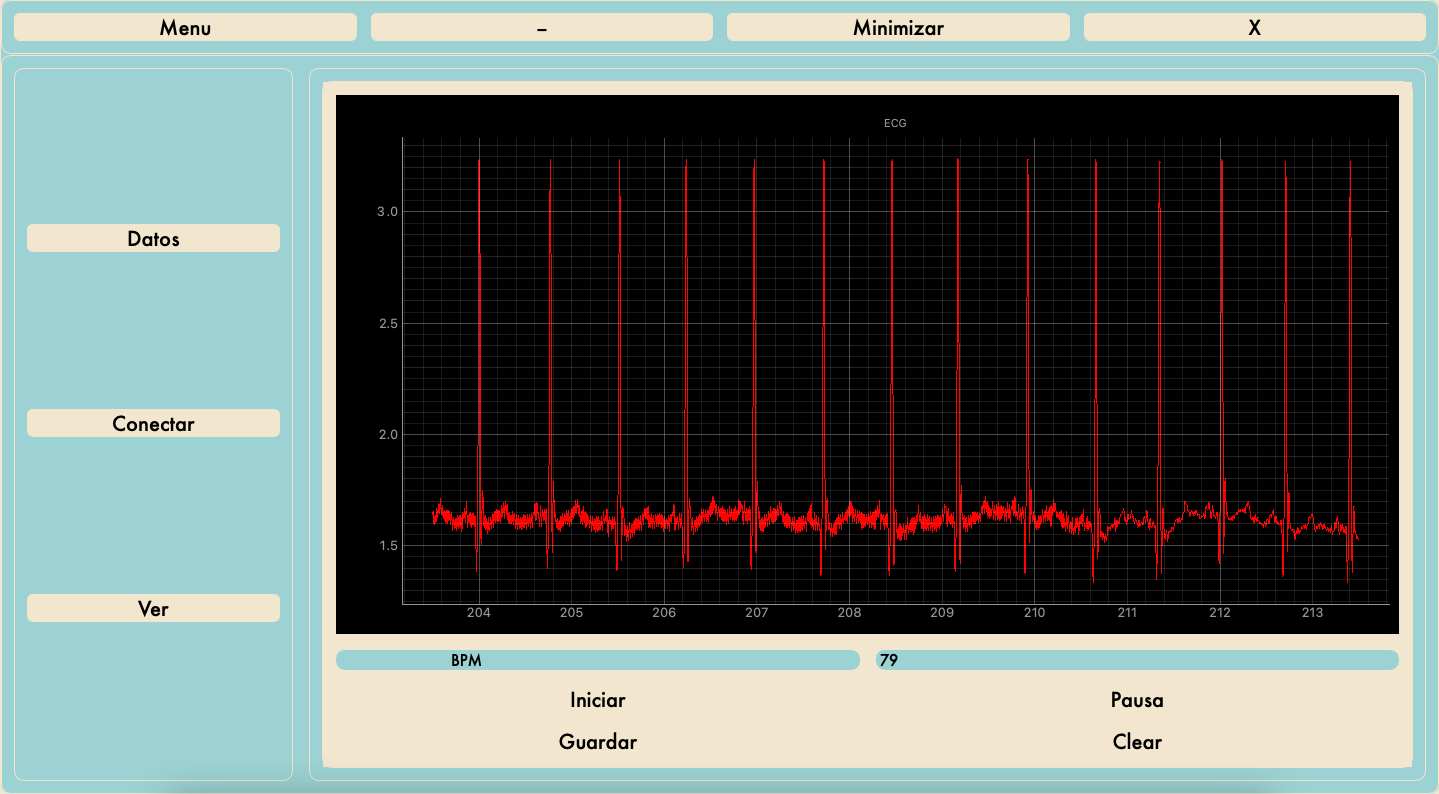

Los valores de amplitud y tiempo se guardan en un archivo .csv, y al completar los datos del paciente, la interfaz los guarda en un archivo NombreDelPaciente.txt. A continuación se muestra el archivo del ejemplo. Se guarda el nombre, la edad, la fecha de nacimiento, el sexo, comentarios adicionales, y la frecuencia cardíaca calculada. Esta frecuencia corresponde aquella que la interfaz muestra cuando se pausa el registro.

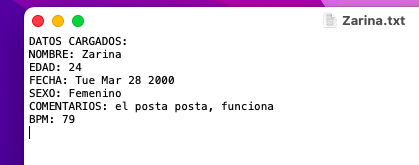

Para calcular la frecuencia cardíaca online se aplicó el algoritmo Pan y Tompkins. Para ello se filtraron los valores levantados del ECG, se aplicó un filtro derivador, los valores obtenidos se elevaron al cuadrado, y se aplicó un filtro integrador. A partir del ECG integrado, se cuentan los picos presentes en el registro y se lo divide por el tiempo de registro en minutos. De esta manera se obtienen los latidos por minutos. Con el fin de asegurar que las funciones utilizadas funcionaron, se optó por graficar por un lado al ECG original y filtrado, y por el otro al original y a todas las señales obtenidas al seguir los pasos del algoritmo.

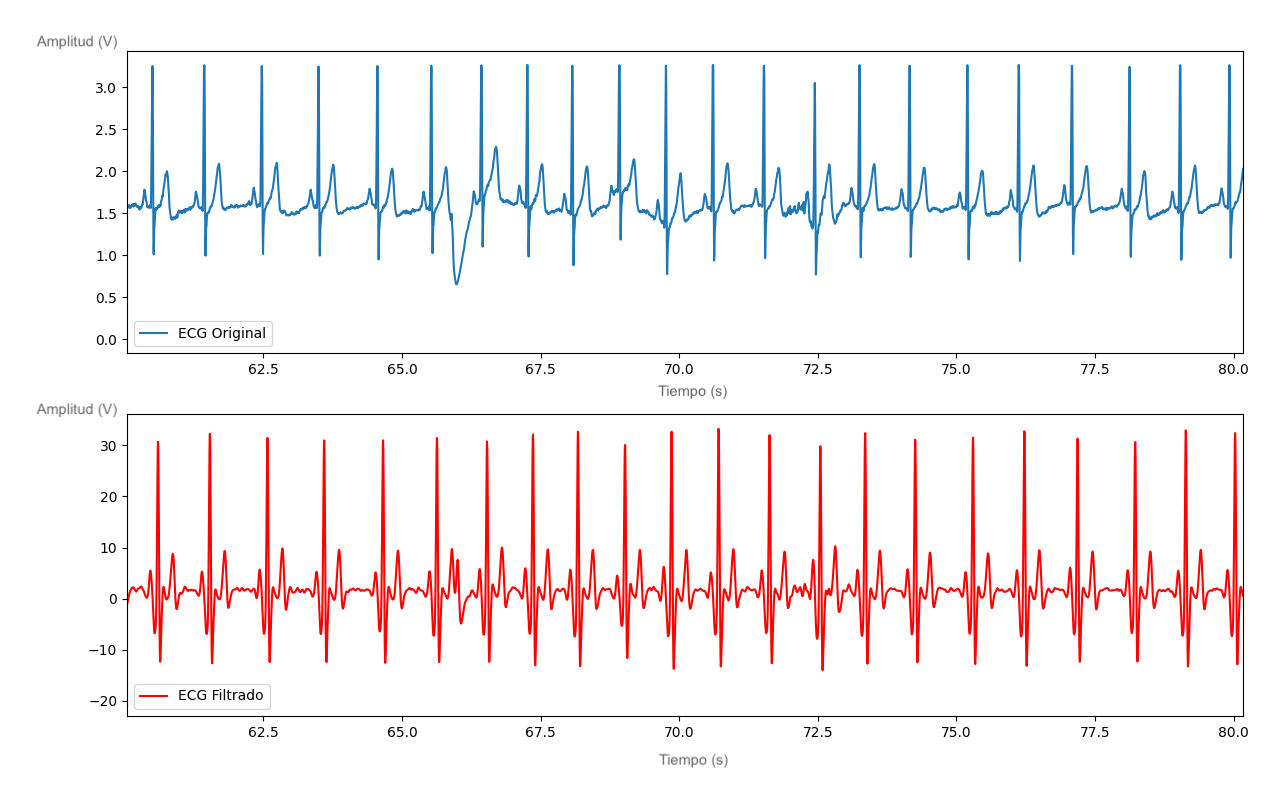

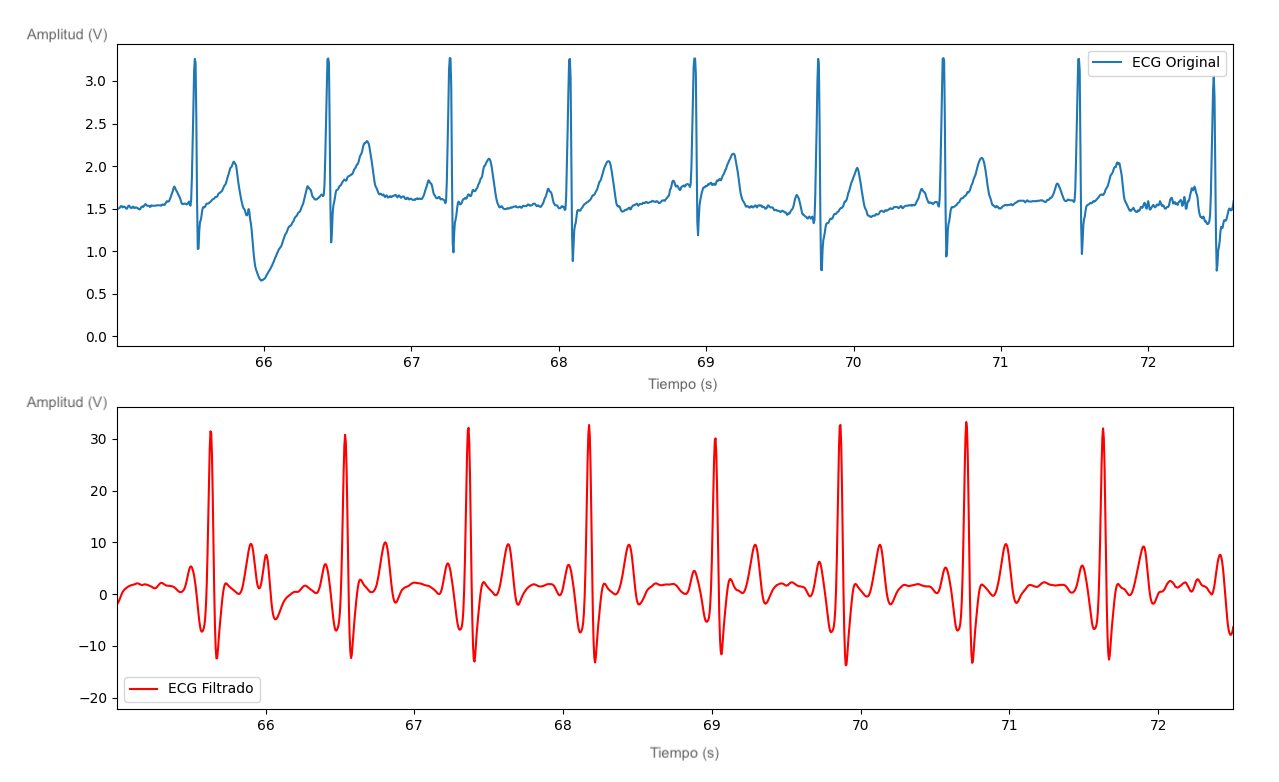

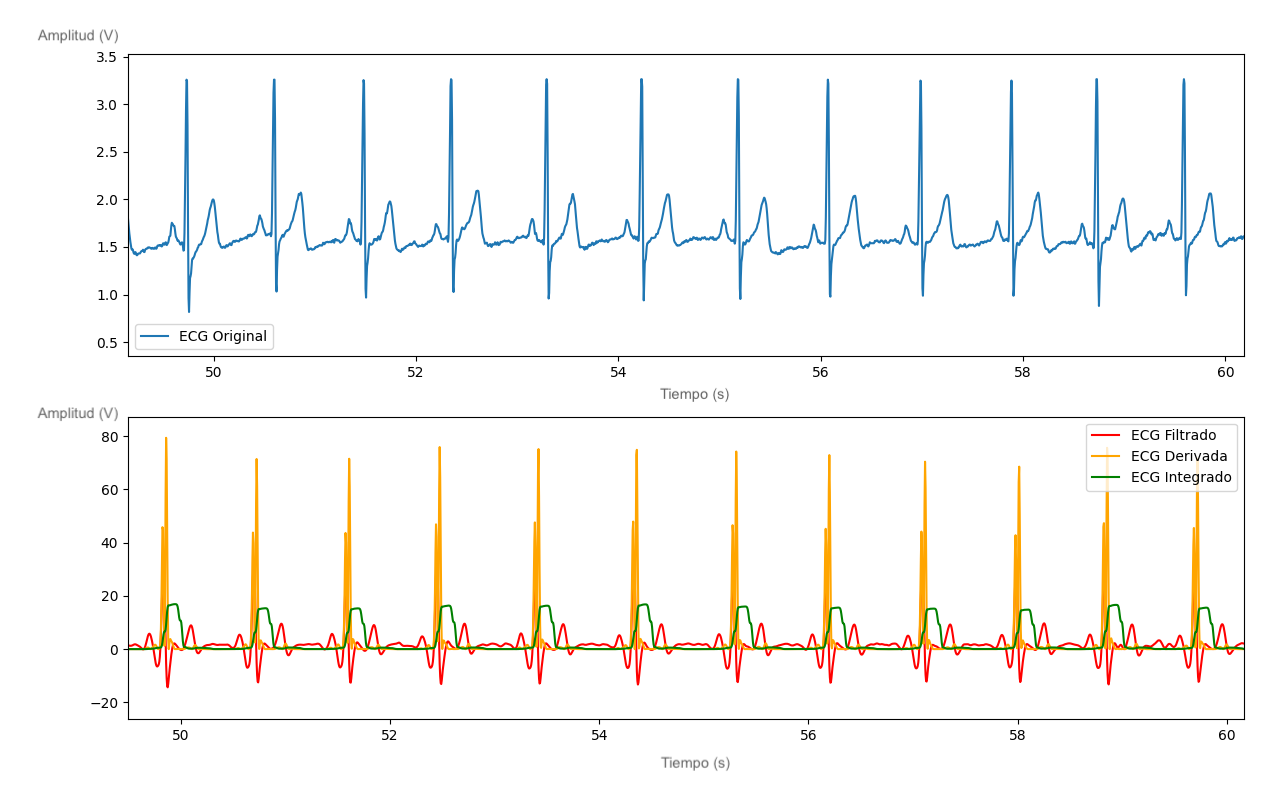

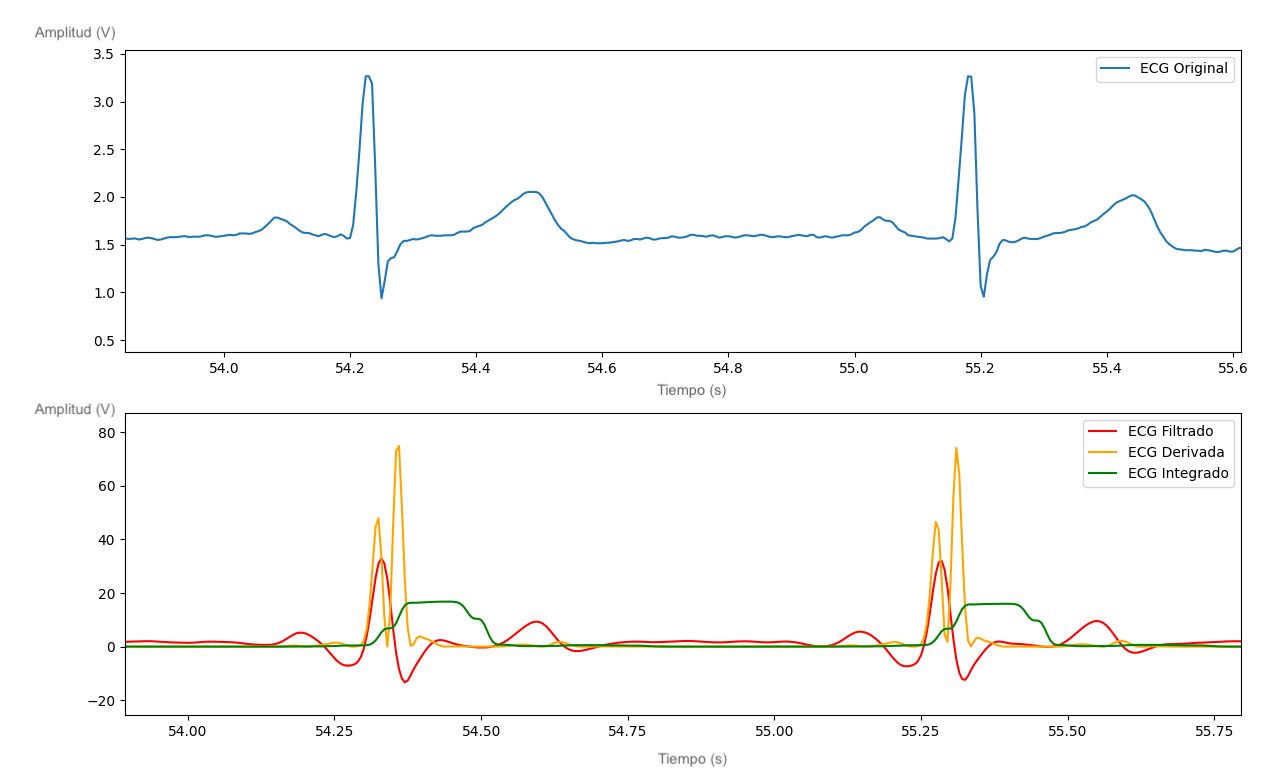

## 2. Intervalo QT

El intervalo QT es un marcador utilizado para estudiar el funcionamiento cardíaco. Se mide desde el inicio del complejo QRS hasta el final de la onda T. Se encuentra relacionado con la frecuencia cardiaca pues a mayores latidos por minuto, menor sera la longitud del intervalo. Para poder determinar si su valor se encuentra dentro de los rangos de normalidad se debe realizar una corrección por frecuencia cardíaca. Para ello se puede utilizar la fórmula de Basset $QT_c = \frac{QT}{\sqrt{RR}}$
[1].

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
import math
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

In [4]:
fs = 200
ruta_archivo = '/content/drive/MyDrive/TP2 PSB/Zarina_ECG.csv'
data = pd.read_csv(ruta_archivo)

# de una columna a una lista
tiempo = data['tiempo'].tolist()
valores = data['datos_ECG'].tolist()

# paso de lista a array
tiempo = np.array(tiempo)
valores = np.array(valores)

In [72]:
def calcular_QT(peaks,valores):
  intervalos_qt = []
  inicios=[]
  finales=[]

  # Recorrer todos los picos detectados
  for pico in peaks:
    # Buscar el inicio del complejo QRS (un poco antes del pico R)
    inicio_qrs = pico - int(0.05 * fs)  # Aproximadamente 100 ms antes del pico R
    if inicio_qrs < 0:
      continue  # Evitar índices negativos

  # Buscar el final de la onda T (un poco después del pico R)
    final_t = pico + int(0.35 * fs)  # Aproximadamente 400 ms después del pico R
    if final_t >= len(valores):
      continue  # Evitar índices fuera de rango

    # Calcular el intervalo QT
    intervalo_qt = tiempo[final_t] - tiempo[inicio_qrs]
    intervalos_qt.append(intervalo_qt)
    inicios.append(inicio_qrs)
    finales.append(final_t)

    # Calcular el promedio del intervalo QT
    if intervalos_qt:
        promedio_qt = np.mean(intervalos_qt)
    else:
        promedio_qt = None

  plt.figure()
  plt.plot(tiempo, valores, label='ECG Original')
  plt.xlim(10, 12)
  plt.plot(tiempo[inicios], valores[inicios], "x")
  plt.plot(tiempo[finales], valores[finales], "x")
  plt.show()

  return promedio_qt

In [79]:
umbral = 0.7*max(valores)
peaks, _ = signal.find_peaks(valores, height=umbral, distance = (0.6*fs))

# tiempo entre picos consecutivos
RR = np.diff(peaks) / fs  # hace la diferencia entre picos y la devuelve en segundos
prom_RR = np.mean(RR)

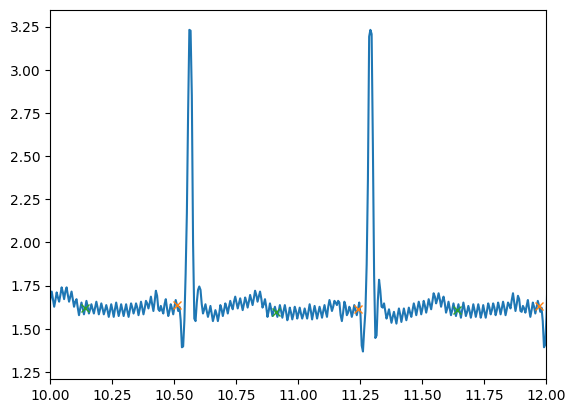

In [80]:
QT = calcular_QT(peaks,valores)

In [81]:
QTc_bazett = QT / math.sqrt(prom_RR)

print("El promedio de los intervalos QT es:", round(QT,4), "segundos")
print("El promedio de los intervalos RR es:", round(prom_RR,4),  "segundos")
print("El QT corregido es:", round(QTc_bazett,4),  "segundos")

El promedio de los intervalos QT es: 0.4 segundos
El promedio de los intervalos RR es: 0.7568 segundos
El QT corregido es: 0.4598 segundos


Para corroborar estos resultados, se calculó también la correción con la ecuación de Fridericia $QTc= \frac{QT}{{\text{{RR}}^{{0.33}}}}$ y la ecuación de Framingham $QTc = QT + 0.154 \times (1 - {RR})$. [2]

In [82]:
QTc_fridericia = QT / (prom_RR)**0.33
print("El QT corregido es:", round(QTc_fridericia,4),  "segundos")

El QT corregido es: 0.4385 segundos


In [83]:
QTc_framingham = QT + (0.154 * (1 - prom_RR))
print("El QT corregido es:", round(QTc_framingham,4),  "segundos")

El QT corregido es: 0.4375 segundos


Según autores [2], los valores normales del intervalo QT se encuentran por debajo de 0,47 segundos para mujeres (como es el caso del sujeto del ejemplo). En este caso, se aplicaron las correcciones de Bazett, Fridericia y Framingham. Si bien los valores fueron disminuyendo respectivamente, todos los valores se encuentran por debajo del umbral pactado.

# Bibliografía

[1] “Intervalo QT,” My-ekg.com, 2016. https://www.my-ekg.com/como-leer-ekg/intervalo-qt.html (accessed Jun. 05, 2024).

[2] L. Tarricone, “Fórmulas para el QT corregido y consideraciones clínicas,” Gaceta Médica de Caracas, vol. 116, no. 3, pp. 224–234, 2024, Accessed: Jun. 05, 2024. [Online]. Available: http://ve.scielo.org/scielo.php?script=sci_arttext&pid=S0367-47622008000300006
‌